# SKTIME

GitHub: https://github.com/alan-turing-institute/sktime

Documentation: https://www.sktime.org/en/stable/index.html


In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.interval_based import SupervisedTimeSeriesForest

import matplotlib.pyplot as plt
%matplotlib inline

## Load Dataset

In [3]:
target = 'activity'
ts_column = 'datetime'

# Train dataset
# Data source: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones
train = pd.read_csv("../data/human-activity-recognition/train.csv")

# Convert labels to binary
train[target] = pd.DataFrame(np.where(train['Activity']=='WALKING_DOWNSTAIRS', 1, 0))

# Drop unused columns
train.drop(['subject', 'Activity'], axis=1, inplace=True)

train.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,0
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,0
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,0


In [4]:
# Test dataset
test = pd.read_csv("../data/human-activity-recognition/test.csv")

# Convert labels to binary
test[target] = pd.DataFrame(np.where(test['Activity']=='WALKING_DOWNSTAIRS', 1, 0))

# Drop unused columns
test.drop(['subject', 'Activity'], axis=1, inplace=True)

test.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,0
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,0
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,0


In [ ]:
print('Train dataset shape:', train.shape)
print('Test dataset shape:', test.shape)

## Preprocess data

In [5]:
# Convert to nested dataframe
features = train.columns.difference([target, 'datetime'])

X_train = train[features]
X_train = from_2d_array_to_nested(X_train)
y_train = train[target]

X_test = test[features]
X_test = from_2d_array_to_nested(X_test)
y_test = test[target]

# X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, shuffle=False, test_size=0.2)

# print('Dataset shape:', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

print('Train dataset shape:', X_train.shape, y_train.shape)
print('Test dataset shape:', X_test.shape, y_test.shape)

Train dataset shape: (7352, 1) (7352,)
Test dataset shape: (2947, 1) (2947,)


In [ ]:
# from sktime.registry import all_estimators

# A list of all available classifiers
# all_estimators("classifier")

A list of all available classifiers:

```
[('Arsenal', sktime.classification.kernel_based._arsenal.Arsenal),
 ('BOSSEnsemble', sktime.classification.dictionary_based._boss.BOSSEnsemble),
 ('CanonicalIntervalForest',
  sktime.classification.interval_based._cif.CanonicalIntervalForest),
 ('Catch22Classifier',
  sktime.classification.feature_based._catch22_classifier.Catch22Classifier),
 ('ClassifierPipeline',
  sktime.classification.compose._pipeline.ClassifierPipeline),
 ('ColumnEnsembleClassifier',
  sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier),
 ('ComposableTimeSeriesForestClassifier',
  sktime.classification.compose._ensemble.ComposableTimeSeriesForestClassifier),
 ('ContractableBOSS',
  sktime.classification.dictionary_based._cboss.ContractableBOSS),
 ('DrCIF', sktime.classification.interval_based._drcif.DrCIF),
 ('ElasticEnsemble',
  sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble),
 ('FreshPRINCE',
  sktime.classification.feature_based._fresh_prince.FreshPRINCE),
 ('HIVECOTEV1', sktime.classification.hybrid._hivecote_v1.HIVECOTEV1),
 ('HIVECOTEV2', sktime.classification.hybrid._hivecote_v2.HIVECOTEV2),
 ('IndividualBOSS',
  sktime.classification.dictionary_based._boss.IndividualBOSS),
 ('IndividualTDE', sktime.classification.dictionary_based._tde.IndividualTDE),
 ('KNeighborsTimeSeriesClassifier',
  sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier),
 ('MUSE', sktime.classification.dictionary_based._muse.MUSE),
 ('MatrixProfileClassifier',
  sktime.classification.feature_based._matrix_profile_classifier.MatrixProfileClassifier),
 ('ProbabilityThresholdEarlyClassifier',
  sktime.classification.early_classification._probability_threshold.ProbabilityThresholdEarlyClassifier),
 ('ProximityForest',
  sktime.classification.distance_based._proximity_forest.ProximityForest),
 ('ProximityStump',
  sktime.classification.distance_based._proximity_forest.ProximityStump),
 ('ProximityTree',
  sktime.classification.distance_based._proximity_forest.ProximityTree),
 ('RandomIntervalClassifier',
  sktime.classification.feature_based._random_interval_classifier.RandomIntervalClassifier),
 ('RandomIntervalSpectralEnsemble',
  sktime.classification.interval_based._rise.RandomIntervalSpectralEnsemble),
 ('RocketClassifier',
  sktime.classification.kernel_based._rocket_classifier.RocketClassifier),
 ('ShapeDTW', sktime.classification.distance_based._shape_dtw.ShapeDTW),
 ('ShapeletTransformClassifier',
  sktime.classification.shapelet_based._stc.ShapeletTransformClassifier),
 ('SignatureClassifier',
  sktime.classification.feature_based._signature_classifier.SignatureClassifier),
 ('SummaryClassifier',
  sktime.classification.feature_based._summary_classifier.SummaryClassifier),
 ('SupervisedTimeSeriesForest',
  sktime.classification.interval_based._stsf.SupervisedTimeSeriesForest),
 ('TEASER', sktime.classification.early_classification._teaser.TEASER),
 ('TSFreshClassifier',
  sktime.classification.feature_based._tsfresh_classifier.TSFreshClassifier),
 ('TemporalDictionaryEnsemble',
  sktime.classification.dictionary_based._tde.TemporalDictionaryEnsemble),
 ('TimeSeriesForestClassifier',
  sktime.classification.interval_based._tsf.TimeSeriesForestClassifier),
 ('WEASEL', sktime.classification.dictionary_based._weasel.WEASEL)]
```

## Train Model

sktime offers three main ways of solving multivariate time series classification problems:
* Concatenation 
* Column-wise ensembling 
* Bespoke estimator-specific methods

Reference: [Multivariate time series classification with sktime](https://www.sktime.org/en/v0.8.1/examples/03_classification_multivariate.html)

### Column ensembling

In [6]:
clf = ColumnEnsembleClassifier(
    estimators=[
        # ("TSF0", TimeSeriesForestClassifier(random_state=42), 0),
        # ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5,random_state=42), 0),
        ('STSF0', SupervisedTimeSeriesForest(n_estimators=5, random_state=42), 0)
    ]
)

clf.fit(X_train, y_train)

print('Training accuracy score', clf.score(X_train, y_train))

Training accuracy score 0.9995919477693145


Exception while using BOSSEnsemble3:

```
TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method
```

In [7]:
# Evaluate the model

# Predict y testues
y_pred = clf.predict(X_test)

# print accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred))

# print precision, recall, F1-score per each class/tag
print('Classification report:')
print(classification_report(y_test, y_pred))

# print confusion matrix, check documentation for sorting rows/columns
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9701391245334238
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2527
           1       0.95      0.83      0.89       420

    accuracy                           0.97      2947
   macro avg       0.96      0.91      0.94      2947
weighted avg       0.97      0.97      0.97      2947

Confusion matrix
[[2510   17]
 [  71  349]]


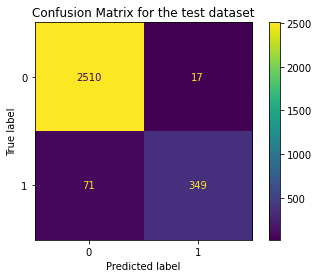

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title('Confusion Matrix for the test dataset')
plt.show()

### Time series concatenation

In [13]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", SupervisedTimeSeriesForest(n_estimators=5, random_state=42)),
]

clf = Pipeline(steps)
clf.fit(X_train, y_train)

Pipeline(steps=[('concatenate', ColumnConcatenator()),
                ('classify',
                 SupervisedTimeSeriesForest(n_estimators=5, random_state=42))])

In [16]:
# Evaluate the model

# Predict y testues
y_pred = clf.predict(X_test)

# print accuracy
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

# print precision, recall, F1-score per each class/tag
print('Classification report:')
print(classification_report(y_test, y_pred))

# print confusion matrix, check documentation for sorting rows/columns
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))

Test Accuracy:  0.9701391245334238
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2527
           1       0.95      0.83      0.89       420

    accuracy                           0.97      2947
   macro avg       0.96      0.91      0.94      2947
weighted avg       0.97      0.97      0.97      2947

Confusion matrix
[[2510   17]
 [  71  349]]


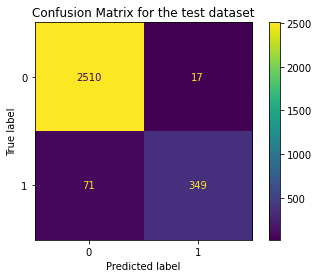

In [15]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title('Confusion Matrix for the test dataset')
plt.show()

In [17]:
# Get the predicited probability of testing data
y_score = clf.predict_proba(X_test)[:, 1]

In [18]:
# Average precision score
average_precision = average_precision_score(y_test, y_score)
print('AVG Precision:', average_precision)

AVG Precision: 0.9277776334012855


In [19]:
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print('AUC:', auc_precision_recall)

AUC: 0.9499754060286587


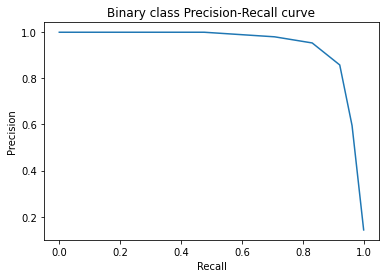

In [20]:
plt.plot(recall, precision)
plt.title('Binary class Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()